<a href="https://colab.research.google.com/github/svsamsonov/ex2mcmc_new/blob/master/colab_notebooks/flex2mcmc_MoG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ex2mcmc

In [ ]:
from typing import Optional
from pathlib import Path
import numpy as np
import torch
from torch.distributions import MultivariateNormal as MNormal
from matplotlib import pyplot as plt
import seaborn as sns

from ex2mcmc.samplers import flex2mcmc, ex2mcmc
from ex2mcmc.models.rnvp_minimal import MinimalRNVP
from ex2mcmc.models.rnvp import RNVP
from ex2mcmc.utils.general_utils import IMGS_DIR, random_seed

from ex2mcmc.pyro_samplers import NUTS, HMC

sns.set_theme('talk', style="white")

In [ ]:
from typing import Iterable, List

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde


def ema(series: Iterable, n: int) -> List:
    """
    returns an n period exponential moving average for
    the time series
    """
    series = np.array(series)
    ema = []
    j = 1

    # get n sma first and calculate the next n period ema
    sma = sum(series[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    # EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(((series[n] - sma) * multiplier) + sma)

    # now calculate the rest of the values
    for i in series[n + 1 :]:
        tmp = ((i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)

    return ema


def plot_result(
    chains, dist, flow=None, chain_id=0, grid_n=100, proj_dim1=-1, proj_dim2=-2
):
    proj_slice = [proj_dim1, proj_dim2]
    proj_dim1 = dist.dim + proj_dim1 + 1 if proj_dim1 < 0 else proj_dim1 + 1
    proj_dim2 = dist.dim + proj_dim2 + 1 if proj_dim2 < 0 else proj_dim2 + 1

    if flow:
        fig, axs = plt.subplots(1, 4, figsize=(17, 4))
    else:
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    result = chains.reshape(-1, chains.shape[-1])
    dist.plot_2d_countour(axs[0])
    xmin, xmax = axs[0].get_xlim()
    ymin, ymax = axs[0].get_ylim()

    axs[0].scatter(
        *result[:, proj_slice].T, alpha=min(0.6, 1000.0 / result.shape[0]), s=10
    )  # , c='r', marker='o')
    axs[0].set_title(f"Projected samples from {chains.shape[1]} chains")

    kernel = gaussian_kde(result[:, proj_slice].T)
    x = np.linspace(xmin, xmax, grid_n)
    y = np.linspace(ymin, ymax, grid_n)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    kde = np.reshape(kernel(positions).T, X.shape)
    axs[1].contour(X, Y, kde, cmap="inferno")
    axs[1].set_title(f"KDE")

    chain_id = 0
    result = chains[:, chain_id]
    dist.plot_2d_countour(axs[2])
    axs[2].plot(
        *result[:, proj_slice].T, "-", alpha=min(0.6, 1000.0 / result.shape[0])
    )  # , c='k')
    axs[2].set_title(f"Trajectory of chain {chain_id}")

    if flow:
        flow_sample = flow.sample((10000,)).detach().cpu()
        kernel = gaussian_kde(flow_sample[:, proj_slice].T)
        kde = np.reshape(kernel(positions).T, X.shape)
        axs[3].contour(X, Y, kde, cmap="inferno")
        axs[3].set_title(f"KDE of NF samples")

    for ax in axs:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_xlabel(rf"$X{proj_dim1}$")
        ax.set_ylabel(rf"$X{proj_dim2}$")

    fig.tight_layout()


In [ ]:
N_CHAINS = 1
N_SAMPLES = 1000
BURN_IN = 1000

PROJ_DIM1 = -2
PROJ_DIM2 = -1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
class MoG(object):
    """
    Mixture of Gaussians distribution.

    Args:
        locs - locations of mean parameters for each Gaussian
        covs - covariances for each Gaussian
    """
    def __init__(self, 
            locs: torch.FloatTensor, 
            covs: torch.FloatTensor, 
            weights: Optional[torch.FloatTensor]=None):
        self.n_comp = len(locs)
        self.locs = locs
        self.covs = covs
        self.weights = weights if weights is not None else \
            torch.ones(self.n_comp, device=locs.device).to(locs.device)
        self.weights /= self.weights.sum()
        self.gaussians = [MNormal(loc, cov) for loc, cov in zip(locs, covs)]

    @property
    def dim(self) -> int:
        return self.locs.shape[-1]

    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        log_ps = torch.stack([
            torch.log(weight) + gauss.log_prob(x) for weight, gauss in zip(self.weights, self.gaussians)
            ], dim=0)
        return torch.logsumexp(log_ps, dim=0)

    def plot_2d_countour(self, ax):
        rad = self.covs.max().cpu() **.5 * 5
        x = np.linspace(self.locs.cpu().min()-rad, self.locs.cpu().max()+rad, 100)
        y = np.linspace(self.locs.cpu().min()-rad, self.locs.cpu().max()+rad, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.FloatTensor(np.stack([X, Y], -1)).to(self.locs.device)

        proj_slice = [PROJ_DIM1, PROJ_DIM2]
        gaussians = [MNormal(loc[proj_slice], cov[proj_slice, :][:, proj_slice]) for loc, cov in zip(self.locs, self.covs)]
        log_ps = torch.stack([
            torch.log(weight) + gauss.log_prob(inp.reshape(-1, 2)) for weight, gauss in zip(self.weights, gaussians)
            ], dim=0)
        Z = torch.logsumexp(log_ps, dim=0).reshape(inp.shape[:-1]).detach().cpu()
        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))

        ax.contour(X, Y, Z.exp(), 
                   #levels = levels, 
                   alpha=1., cmap='inferno')


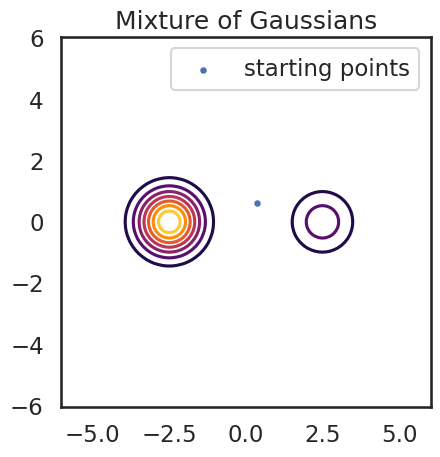

In [ ]:
dim = 100
locs = torch.FloatTensor([[2.5]*(dim-1) + [0], [-2.5]*(dim-1) + [0]])
covs = 0.5 * torch.eye(dim)[None, ...].repeat(2, 1, 1).float()
weights = torch.FloatTensor([1, 3])

mog = MoG(locs.to(device), covs.to(device), weights.to(device))

ax = plt.subplot()
mog.plot_2d_countour(ax)

random_seed(42)

start_mog = torch.randn((N_CHAINS, mog.dim))

proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_mog[:, proj_slice].T, s=10, label='starting points')
plt.title('Mixture of Gaussians')
plt.legend()
ax.set_aspect('equal')
plt.show()

In [ ]:
step_size = 0.1

random_seed(42)

chains = NUTS(start_mog.to(device), mog, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

Sample: 100%|██████████| 2000/2000 [01:05, 30.62it/s, step size=4.97e-01, acc. prob=0.829]


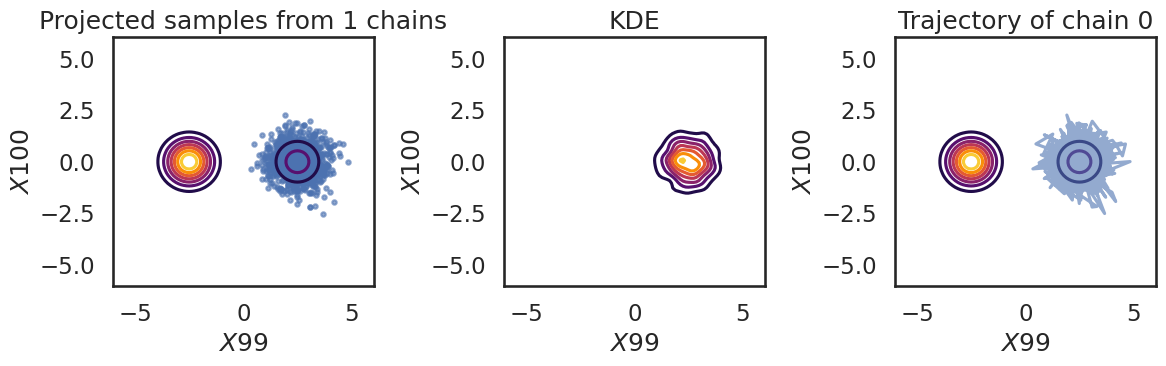

In [ ]:
plot_result(chains.cpu(), mog, proj_dim1=PROJ_DIM1, proj_dim2=PROJ_DIM2)

In [ ]:
step_size = 0.1
target_acceptance = 0.5
n_particles = 10
n_mala_steps = 1
train_steps = 100
batch_size = 100
prior_scale = 3
backward_kl_weight = 0.005
forward_kl_weight = 1 - backward_kl_weight

proposal = RNVP(num_blocks=4, dim=dim, device=device, scale=prior_scale)
opt = torch.optim.Adam(proposal.parameters(), 1e-3)
proposal.optim = opt
proposal.train()
proposal.scheduler = torch.optim.lr_scheduler.LambdaLR(
    opt, lambda it: int(it < train_steps)
)

random_seed(42)

# train
flex2mcmc(
    proposal.prior.sample((batch_size,)),
    mog, 
    proposal, 
    1,
    train_steps,
    project=lambda x: x, 
    step_size=step_size, 
    n_particles=n_particles, 
    n_mala_steps=n_mala_steps,
    forward_kl_weight=forward_kl_weight,
    backward_kl_weight=backward_kl_weight,
    target_acceptance=target_acceptance,
    verbose=True)

proposal.eval()

# sample
chains, meta = flex2mcmc(
    start_mog.to(device), 
    mog, 
    proposal, 
    N_SAMPLES,
    BURN_IN,
    project=lambda x: x, 
    step_size=step_size, 
    n_particles=n_particles, 
    n_mala_steps=1, 
    target_acceptance=target_acceptance,
    verbose=True)
chains = chains.detach().cpu()

KL forw 113.454,                      KL back 160.198 : 100%|██████████| 101/101 [00:10<00:00, 10.06it/s]
100%|██████████| 2000/2000 [00:31<00:00, 64.48it/s]


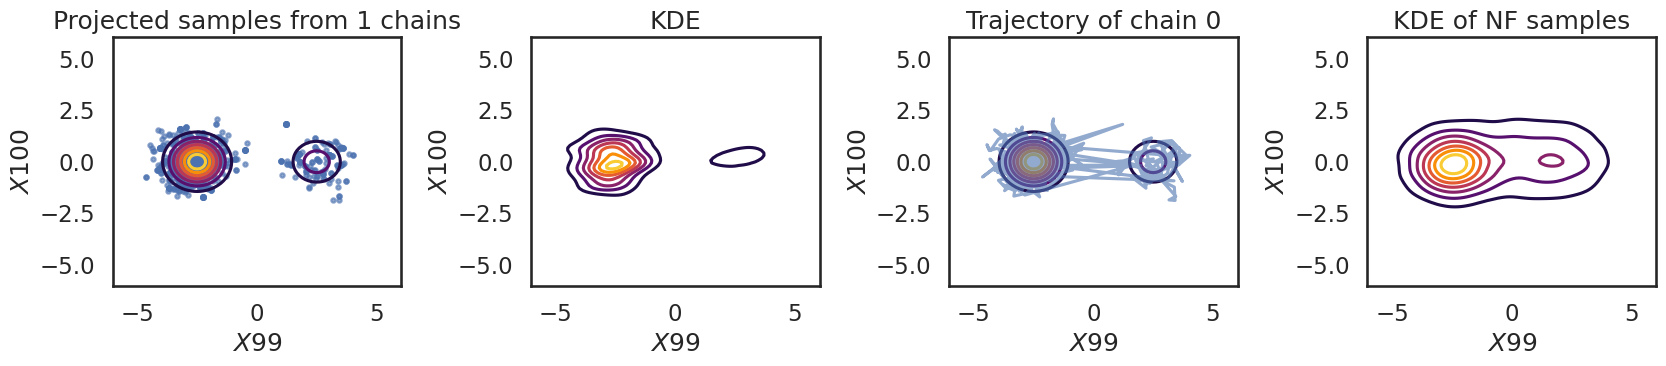

In [ ]:
plot_result(chains.cpu(), mog, proposal, proj_dim1=PROJ_DIM1, proj_dim2=PROJ_DIM2)

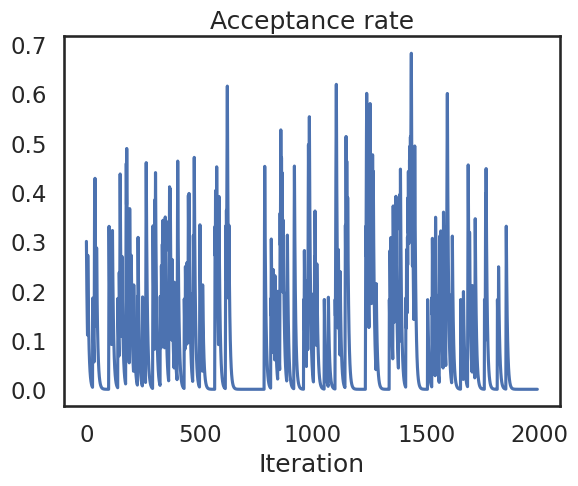

In [ ]:
plt.plot(ema(meta['sir_accept'], 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')
plt.show()